# Machine Learning - Segmentation

From: https://github.com/bnsreenu/python_for_microscopists/blob/master/068b-ML_06_04_TRAIN_ML_segmentation_All_filters_RForest_SVM.py \
and https://www.youtube.com/watch?v=blrXmOOWdvQ&ab_channel=DigitalSreeni

In [1]:
from SpykFunctions import *
import numpy as np
import cv2
import pandas as pd

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600

## Read image and save in df

In [ ]:
%%time
images_path = r'.\CVATLabeling\TROE2021_p003-p012\images\default'
Images = ListImages(images_path, imgformat=".tif", recursive=False)

masks_path = r'.\CVATLabeling\TROE2021_p003-p012\masks'
Masks = ListImages(masks_path, imgformat=".tif", recursive=False)


img = cv2.imread(Images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
# plt.imshow(img)

# Resize image 
ResizeFactor = 8
im = Image.fromarray((img).astype(np.uint8))
(width, height) = (im.width // ResizeFactor, im.height // ResizeFactor)
resized_img = im.resize((width, height))
resized_img = np.asarray(resized_img)
img = resized_img

# # Increase to original size
# (width, height) = (im.width, im.height)
# rescaled_spk = rescaled_spk.resize((width, height))
# rescaled_spk = np.asarray(rescaled_spk)




#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 

#Multiple images can be used for training. For that, you need to concatenate the data

#Save original image pixels into a data frame. This is our Feature #1.
img2 = img.reshape(-1)
df = pd.DataFrame()
df['Original Image'] = img2

## Generate features

In [ ]:
%%time

#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 600
# ThisFilter = 'Gabor1'
# plt.imshow(np.array(df[ThisFilter]).reshape(img.shape[0],img.shape[1]))        
# plt.imshow(edge_scharr)
                
                
########################################
#Gerate OTHER FEATURES and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
# plt.imshow(edges)
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe


# on CPU with resize=1 --> Wall time: 13min 8s
# on CPU with ResizeFactor=8 --> Wall time: 11.9sec

## Add labels as column to df

In [ ]:
%%time
#Now, add a column in the data frame for the Labels
#For this, we need to import the labeled image
# labeled_img = cv2.imread(Masks[0])
labeled_img = plt.imread(Masks[0])
labeled_img = labeled_img.astype(np.uint8)
labeled_img = labeled_img[:,:,0]
# plt.imshow(labeled_img)
kernel = np.ones((3,3), np.uint8)
labeled_img = cv2.erode(labeled_img, kernel, iterations=1)
# plt.imshow(labeled_img)

# Resize image 
# ResizeFactor = 8
im = Image.fromarray((labeled_img).astype(np.uint8))
(width, height) = (im.width // ResizeFactor, im.height // ResizeFactor)
resized_labeled_img = im.resize((width, height))
resized_labeled_img = np.asarray(resized_labeled_img)
# labeled_img = resized_labeled_img
# plt.imshow(labeled_img)

nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(resized_labeled_img, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1    

resized_labeled_img = np.zeros((output.shape))

# Keep only objects with minimum size
for i in range(0, nb_components):
    if sizes[i] >= 30 and sizes[i] < 200:
        resized_labeled_img[output == i + 1] = 1

resized_labeled_img = np.uint8(resized_labeled_img)
# plt.imshow(resized_labeled_img)
labeled_img = resized_labeled_img

    
#Remember that you can load an image with partial labels 
#But, drop the rows with unlabeled data
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

# print(df.head())

#df.to_csv("Gabor.csv")

# on CPU with ResizeFactor=8 --> Wall time: 1.39 s

## Variable to predict

In [ ]:
%%time
#Define the dependent variable that needs to be predicted (labels)
Y = df["Labels"].values

#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)

# on CPU with ResizeFactor=8 --> Wall time: 2.5 s

## Import models

### RandomForestRegressor

In [ ]:
%%time
#RandomForestRegressor is for regression type of problems. 
#For classification we use RandomForestClassifier.
#Both yield similar results except for regressor the result is float
#and for classifier it is an integer. 

from sklearn.ensemble import RandomForestClassifier
# Instantiate model with n number of decision trees
model = RandomForestClassifier(n_estimators = 100, random_state = 42)

# on CPU with ResizeFactor=8 --> Wall time: 2.36 s

### SVM

In [ ]:
%%time
#SVM
# Train the Linear SVM to compare against Random Forest
#SVM will be slower than Random Forest. 
#Make sure to comment out Fetaure importances lines of code as it does not apply to SVM.
from sklearn.svm import LinearSVC
model_svm = LinearSVC(max_iter=100)  #Default of 100 is not converging

## Train the model

In [ ]:
%%time
# Train the model on training data

# model.fit(X_train, y_train)
model_svm.fit(X_train, y_train)

# verify number of trees used. If not defined above. 
# print('Number of Trees used : ', model.n_estimators)

# on CPU with ResizeFactor=8 --> Wall time: 22.7 s with Random Forest

## Predictions

### On train

In [ ]:
%%time
#STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA
#AND CALCULATE THE ACCURACY SCORE
#First test prediction on the training data itself. SHould be good. 
# prediction_test_train = model.predict(X_train)
prediction_test_train = model_svm.predict(X_train)

# on CPU with ResizeFactor=1 --> Wall time: 6min 25s
# on CPU with ResizeFactor=1 --> Wall time: 2.62 s

### On test

In [ ]:
%%time
#Test prediction on testing data. 
# prediction_test = model.predict(X_test)
prediction_test = model_svm.predict(X_test)

# on CPU with ResizeFactor=1 --> Wall time: 4min 14s
# on CPU with ResizeFactor=8 --> Wall time: 1.73 s

In [ ]:
#.predict just takes the .predict_proba output and changes everything 
#to 0 below a certain threshold (usually 0.5) respectively to 1 above that threshold.
#In this example we have 4 labels, so the probabilities will for each label stored separately. 
# 
#prediction_prob_test = model.predict_proba(X_test)

## Check accuracy

In [ ]:
%%time
#Let us check the accuracy on test data
from sklearn import metrics
#Print the prediction accuracy

#First check the accuracy on training data. This will be higher than test data prediction accuracy.
print ("Accuracy on training data = ", metrics.accuracy_score(y_train, prediction_test_train))
#Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))


In [ ]:
%%time
#This part commented out for SVM testing. Uncomment for random forest. 
#One amazing feature of Random forest is that it provides us info on feature importances
# Get numerical feature importances
#importances = list(model.feature_importances_)

#Let us print them into a nice format.

feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

## Store model for future use

In [ ]:
#You can store the model for future use. In fact, this is how you do machine elarning
#Train on training images, validate on test images and deploy the model on unknown images. 

import pickle

#Save the trained model as pickle string to disk for future use
# Resize Factor = 8
# filename = "Models/sandstone_model_resizeF08"
filename = "Models/sandstone_model_svm_resizeF08"
pickle.dump(model, open(filename, 'wb'))

#To test the model on future datasets
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X)

segmented = result.reshape((img.shape))

from matplotlib import pyplot as plt
plt.imshow(segmented, cmap ='jet')
plt.imsave('segmented_rock_RF_100_estim_resizeF08.jpg', segmented, cmap ='jet')

# Predict spikelets on new image

In [ ]:
%%time

img = cv2.imread(Images[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
# plt.imshow(img)

# Resize image 
ResizeFactor = 8
im = Image.fromarray((img).astype(np.uint8))
(width, height) = (im.width // ResizeFactor, im.height // ResizeFactor)
resized_img = im.resize((width, height))
resized_img = np.asarray(resized_img)
img = resized_img
# plt.imshow(img)
#Save original image pixels into a data frame. This is our Feature #1.
img2 = img.reshape(-1)
df = pd.DataFrame()
df['Original Image'] = img2

#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 600
# ThisFilter = 'Gabor1'
# plt.imshow(np.array(df[ThisFilter]).reshape(img.shape[0],img.shape[1]))        
# plt.imshow(edge_scharr)
                
                
########################################
#Gerate OTHER FEATURES and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
# plt.imshow(edges)
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe



#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 

#Multiple images can be used for training. For that, you need to concatenate the data

#Save original image pixels into a data frame. This is our Feature #1.

X = df
#To test the model on future datasets
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X)

segmented = result.reshape((img.shape))

from matplotlib import pyplot as plt
plt.imshow(segmented, cmap ='jet')

# Put into functions

In [3]:
%%time
images_path = r'.\CVATLabeling\TROE2021_p003-p012\images\default'
Images = ListImages(images_path, imgformat=".tif", recursive=False)

masks_path = r'.\CVATLabeling\TROE2021_p003-p012\masks'
Masks = ListImages(masks_path, imgformat=".tif", recursive=False)

Wall time: 6 ms


## `read_and_resize`

In [10]:
# image_path = Images[0]
ResizeFactor = 8

def read_and_Resize(image_path, ResizeFactor = 8, mask=False):
    
    if mask==True:
        labeled_img = plt.imread(image_path)
        labeled_img = labeled_img.astype(np.uint8)
        labeled_img = labeled_img[:,:,0]
        # plt.imshow(labeled_img)
        kernel = np.ones((3,3), np.uint8)
        labeled_img = cv2.erode(labeled_img, kernel, iterations=1)
        im = Image.fromarray((labeled_img).astype(np.uint8))
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
        im = Image.fromarray((img).astype(np.uint8))

    # Resize image 
    (width, height) = (im.width // ResizeFactor, im.height // ResizeFactor)
    resized_img = im.resize((width, height))
    resized_img = np.asarray(resized_img)
    
    return(resized_img)

# img = read_and_Resize(image_path, ResizeFactor = ResizeFactor, mask=False)

## `features_to_df`

In [11]:

def features_to_df(img, df_original):
    img2 = img.reshape(-1)
    df = df_original.copy()

    #Generate Gabor features
    num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []
    for theta in range(2):   #Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5


                    gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1  #Increment for gabor column label
                
                
    ########################################
    #Gerate OTHER FEATURES and add them to the data frame

    #CANNY EDGE
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    # plt.imshow(edges)
    edges1 = edges.reshape(-1)
    df['Canny Edge'] = edges1 #Add column to original dataframe

    from skimage.filters import roberts, sobel, scharr, prewitt

    #ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    #SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1

    #SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1

    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    #GAUSSIAN with sigma=3
    from scipy import ndimage as nd
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1

    #GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3

    #MEDIAN with sigma=3
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1

    #VARIANCE with size=3
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3'] = variance_img1  #Add column to original dataframe
    
    return(df)

# df2 = features_to_df(img, df_original=df)
# df = df2

## `add_labels`

In [12]:
def add_labels(mask_path, MinSize=30, MaxSize=200):
    # MMinSize=30, MaxSize=200 was decided for ResizeFator=8
    resized_labeled_img = read_and_Resize(mask_path, ResizeFactor = 8, mask=True)
    
    # Detect connected components
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(resized_labeled_img, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1    

    resized_labeled_img = np.zeros((output.shape))
    unlabeled = np.zeros((output.shape))

    # Keep only objects with minimum size
    for i in range(0, nb_components):
        if sizes[i] >= MinSize and sizes[i] < MaxSize:
            resized_labeled_img[output == i + 1] = 1
        else:
            unlabeled[output == i + 1] = 1

    resized_labeled_img = np.uint8(resized_labeled_img)
    unlabeled = np.uint8(unlabeled)
    # plt.imshow(resized_labeled_img)
    labeled_img = resized_labeled_img
    
    return(labeled_img, unlabeled)

# labeled, unlabeled = add_labels(mask_path=Masks[0], MinSize=30, MaxSize=200)

## `CollectTrainData`

In [13]:
def CollectTrainData(image_path, mask_path, ResizeFactor=ResizeFactor):
    
    # Create empty df
    df = pd.DataFrame()
    
    img = read_and_Resize(image_path, ResizeFactor = ResizeFactor, mask=False)

    img2 = img.reshape(-1)
    
    df['Original Image'] = img2
    
    df = features_to_df(img, df_original=df)
    
    labeled, unlabeled = add_labels(mask_path=mask_path, MinSize=30, MaxSize=200)

    #Remember that you can load an image with partial labels 
    #But, drop the rows with unlabeled data
    df['Labels'] = labeled.reshape(-1)
    df['ToDrop'] = unlabeled.reshape(-1)

    df = df.drop(df[df['ToDrop'] == 1].index)
    df = df.drop(labels = ["ToDrop"], axis=1)
    Image_Name =  image_path.split('\\')[-1]
    df['Image_Name'] = [Image_Name] * len(df['Labels'])
    
    return(df)
    

## Collect data for TROE 003-009

In [14]:
%%time

images_path = r'.\CVATLabeling\TROE2021_p003-p012\images\default'
Images = ListImages(images_path, imgformat=".tif", recursive=False)

masks_path = r'.\CVATLabeling\TROE2021_p003-p012\masks'
Masks = ListImages(masks_path, imgformat=".tif", recursive=False)

ResizeFactor = 8
df_all = pd.DataFrame()

for i in range(0,len(Images)):
    df = CollectTrainData(image_path=Images[i],mask_path=Masks[i], ResizeFactor=8)
    df_all = df_all.append(df)

# Wall time: 1min 33s
# About 13 sec per image/label

Wall time: 1min 37s


## Collect data for RPGR Roseau JON

In [15]:
%%time

images_path = r'.\CVATLabeling\PGRRoseau_JON\images\default'
Images = ListImages(images_path, imgformat=".tif", recursive=False)

masks_path = r'.\CVATLabeling\PGRRoseau_JON\masks'
Masks = ListImages(masks_path, imgformat=".tif", recursive=False)

ResizeFactor = 8
df_all_2 = pd.DataFrame()

for i in range(0,len(Images)):
    df = CollectTrainData(image_path=Images[i],mask_path=Masks[i], ResizeFactor=8)
    df_all_2 = df_all.append(df)


IndexError: list index out of range

## Combine Roseau and TROE

In [17]:
df_comb = pd.concat([df_all, df_all_2])
df_comb

,Original Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Roberts,Sobel,Scharr,Prewitt,Gaussian s3,Gaussian s7,Median s3,Variance s3,Labels,Image_Name
0,27,0,0,109,62,35,20,14,8,0,...,0.032457,0.027608,0.028785,0.026046,18,16,21,20,0,p003P1812.tif
1,21,0,0,108,61,35,20,14,8,0,...,0.017538,0.018315,0.018506,0.018207,18,16,21,13,0,p003P1812.tif
2,22,0,0,107,60,35,19,14,8,0,...,0.008769,0.008085,0.008945,0.007039,18,16,19,3,0,p003P1812.tif
3,18,0,0,104,57,34,19,14,8,0,...,0.006201,0.004902,0.003805,0.006665,17,16,19,3,0,p003P1812.tif
4,21,0,0,100,55,32,18,13,7,0,...,0.011765,0.007137,0.008451,0.005390,17,16,19,1,0,p003P1812.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559521,170,0,0,255,255,255,158,117,64,0,...,0.003922,0.067711,0.072427,0.061459,139,102,169,124,0,JONPGR_ROSEAU2021__0007.tif
559522,169,0,0,255,255,255,158,118,64,0,...,0.035294,0.063756,0.060874,0.068087,146,105,170,158,0,JONPGR_ROSEAU2021__0007.tif
559523,178,0,0,255,255,255,159,118,65,0,...,0.007843,0.045236,0.041337,0.050568,152,107,178,83,0,JONPGR_ROSEAU2021__0007.tif
559524,180,0,0,255,255,255,160,117,65,0,...,0.019608,0.007466,0.007789,0.007039,157,109,178,4,0,JONPGR_ROSEAU2021__0007.tif


## Split data

In [18]:
%%time

df = df_all
df = df.drop(labels = ["Image_Name"], axis=1)

#Define the dependent variable that needs to be predicted (labels)
Y = df["Labels"].values

#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.4, 
                                                    random_state=20)

Wall time: 3.75 s


## Train Models

### RandomForestRegressor

In [24]:
%%time
#RandomForestRegressor is for regression type of problems. 
#For classification we use RandomForestClassifier.
#Both yield similar results except for regressor the result is float
#and for classifier it is an integer. 

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with n number of decision trees
model_RFC = RandomForestClassifier(n_estimators = 100, random_state = 0)
# model_RFC2 = RandomForestClassifier(n_estimators = 50, random_state = 0)

# Train the model on training data
model_RFC.fit(X_train, y_train)
# model_RFC2.fit(X_train, y_train)

# on CPU with ResizeFactor=8 --> Wall time: 2.36 s

# RandomForestClassifier(n_estimators=1000, random_state=42) --> Wall time: 2h 57min 32s

Wall time: 18min 2s


RandomForestClassifier(random_state=0)

### SVM

In [25]:
%%time

# Train the Linear SVM to compare against Random Forest
#SVM will be slower than Random Forest. 
#Make sure to comment out Fetaure importances lines of code as it does not apply to SVM.
from sklearn.svm import LinearSVC

model_SVM = LinearSVC(max_iter=100)  #Default of 100 is not converging
# model_SVM2 = LinearSVC(max_iter=300)  #Default of 100 is not converging
model_SVM.fit(X_train, y_train)
# model_SVM2.fit(X_train, y_train)

# on CPU with ResizeFactor=8 100 iter --> Wall time: 2.36 s
# on CPU with ResizeFactor=8 1000 iter --> Wall time: 19min 15s

Wall time: 1min 47s


J:\My Drive\M.Sc\THESIS\ImageAnalysis\SpikeProperties\envspk\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100)

## Predictions

### On train

In [14]:
%%time

#First test prediction on the training data itself. SHould be good. 
prediction_test_train_RFC = model_RFC.predict(X_train)
prediction_test_train_SVM = model_SVM.predict(X_train)

# on CPU with ResizeFactor=1 --> Wall time: 6min 25s
# on CPU with ResizeFactor=1 --> Wall time: 2.62 s

# on CPU (RFC + SVM) ResizeFactor=8 --> Wall time: 12min 52s

Wall time: 4min 4s


### On test

In [15]:
%%time
#Test prediction on testing data. 
prediction_test_RFC = model_RFC.predict(X_test)
prediction_test_SVM = model_SVM.predict(X_test)

# on CPU with ResizeFactor=1 --> Wall time: 4min 14s
# on CPU with ResizeFactor=8 --> Wall time: 1.73 s

# on CPU (RFC + SVM) ResizeFactor=8 --> Wall time: 8min 31s

Wall time: 2min 59s


In [ ]:
#.predict just takes the .predict_proba output and changes everything 
#to 0 below a certain threshold (usually 0.5) respectively to 1 above that threshold.
#In this example we have 4 labels, so the probabilities will for each label stored separately. 
# 
#prediction_prob_test = model.predict_proba(X_test)

## Check accuracy

In [16]:
%%time
#Let us check the accuracy on test data
from sklearn import metrics
#Print the prediction accuracy

#First check the accuracy on training data. This will be higher than test data prediction accuracy.
print ("Accuracy on training data for RFC = ", metrics.accuracy_score(y_train, prediction_test_train_RFC))
print ("Accuracy on training data for SVM = ", metrics.accuracy_score(y_train, prediction_test_train_SVM))


#Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
print ("Accuracy for RFC = ", metrics.accuracy_score(y_test, prediction_test_RFC))
print ("Accuracy for SVM = ", metrics.accuracy_score(y_test, prediction_test_SVM))


Accuracy on training data for RFC =  0.996231999149455
Accuracy on training data for SVM =  0.9670092713737386
Accuracy for RFC =  0.9759072455315501
Accuracy for SVM =  0.9667747422167052
Wall time: 849 ms


In [ ]:
%%time
#This part commented out for SVM testing. Uncomment for random forest. 
#One amazing feature of Random forest is that it provides us info on feature importances
# Get numerical feature importances
feature_list = list(X.columns)
feature_imp = pd.Series(model_RFC.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

## Predict on new image

In [30]:
%%time

myimage = "J:\My Drive\M.Sc\THESIS\ImageAnalysis\SpikeProperties\SpykProps\Images\TROE2020\H2B1_016_16.tif"
# Create empty df
df = pd.DataFrame()

img = read_and_Resize(myimage, ResizeFactor = 8, mask=False)
img2 = img.reshape(-1)
df['Original Image'] = img2
df = features_to_df(img, df_original=df)

#Define the independent variables
X = df

Wall time: 10.7 s


Wall time: 8.22 s


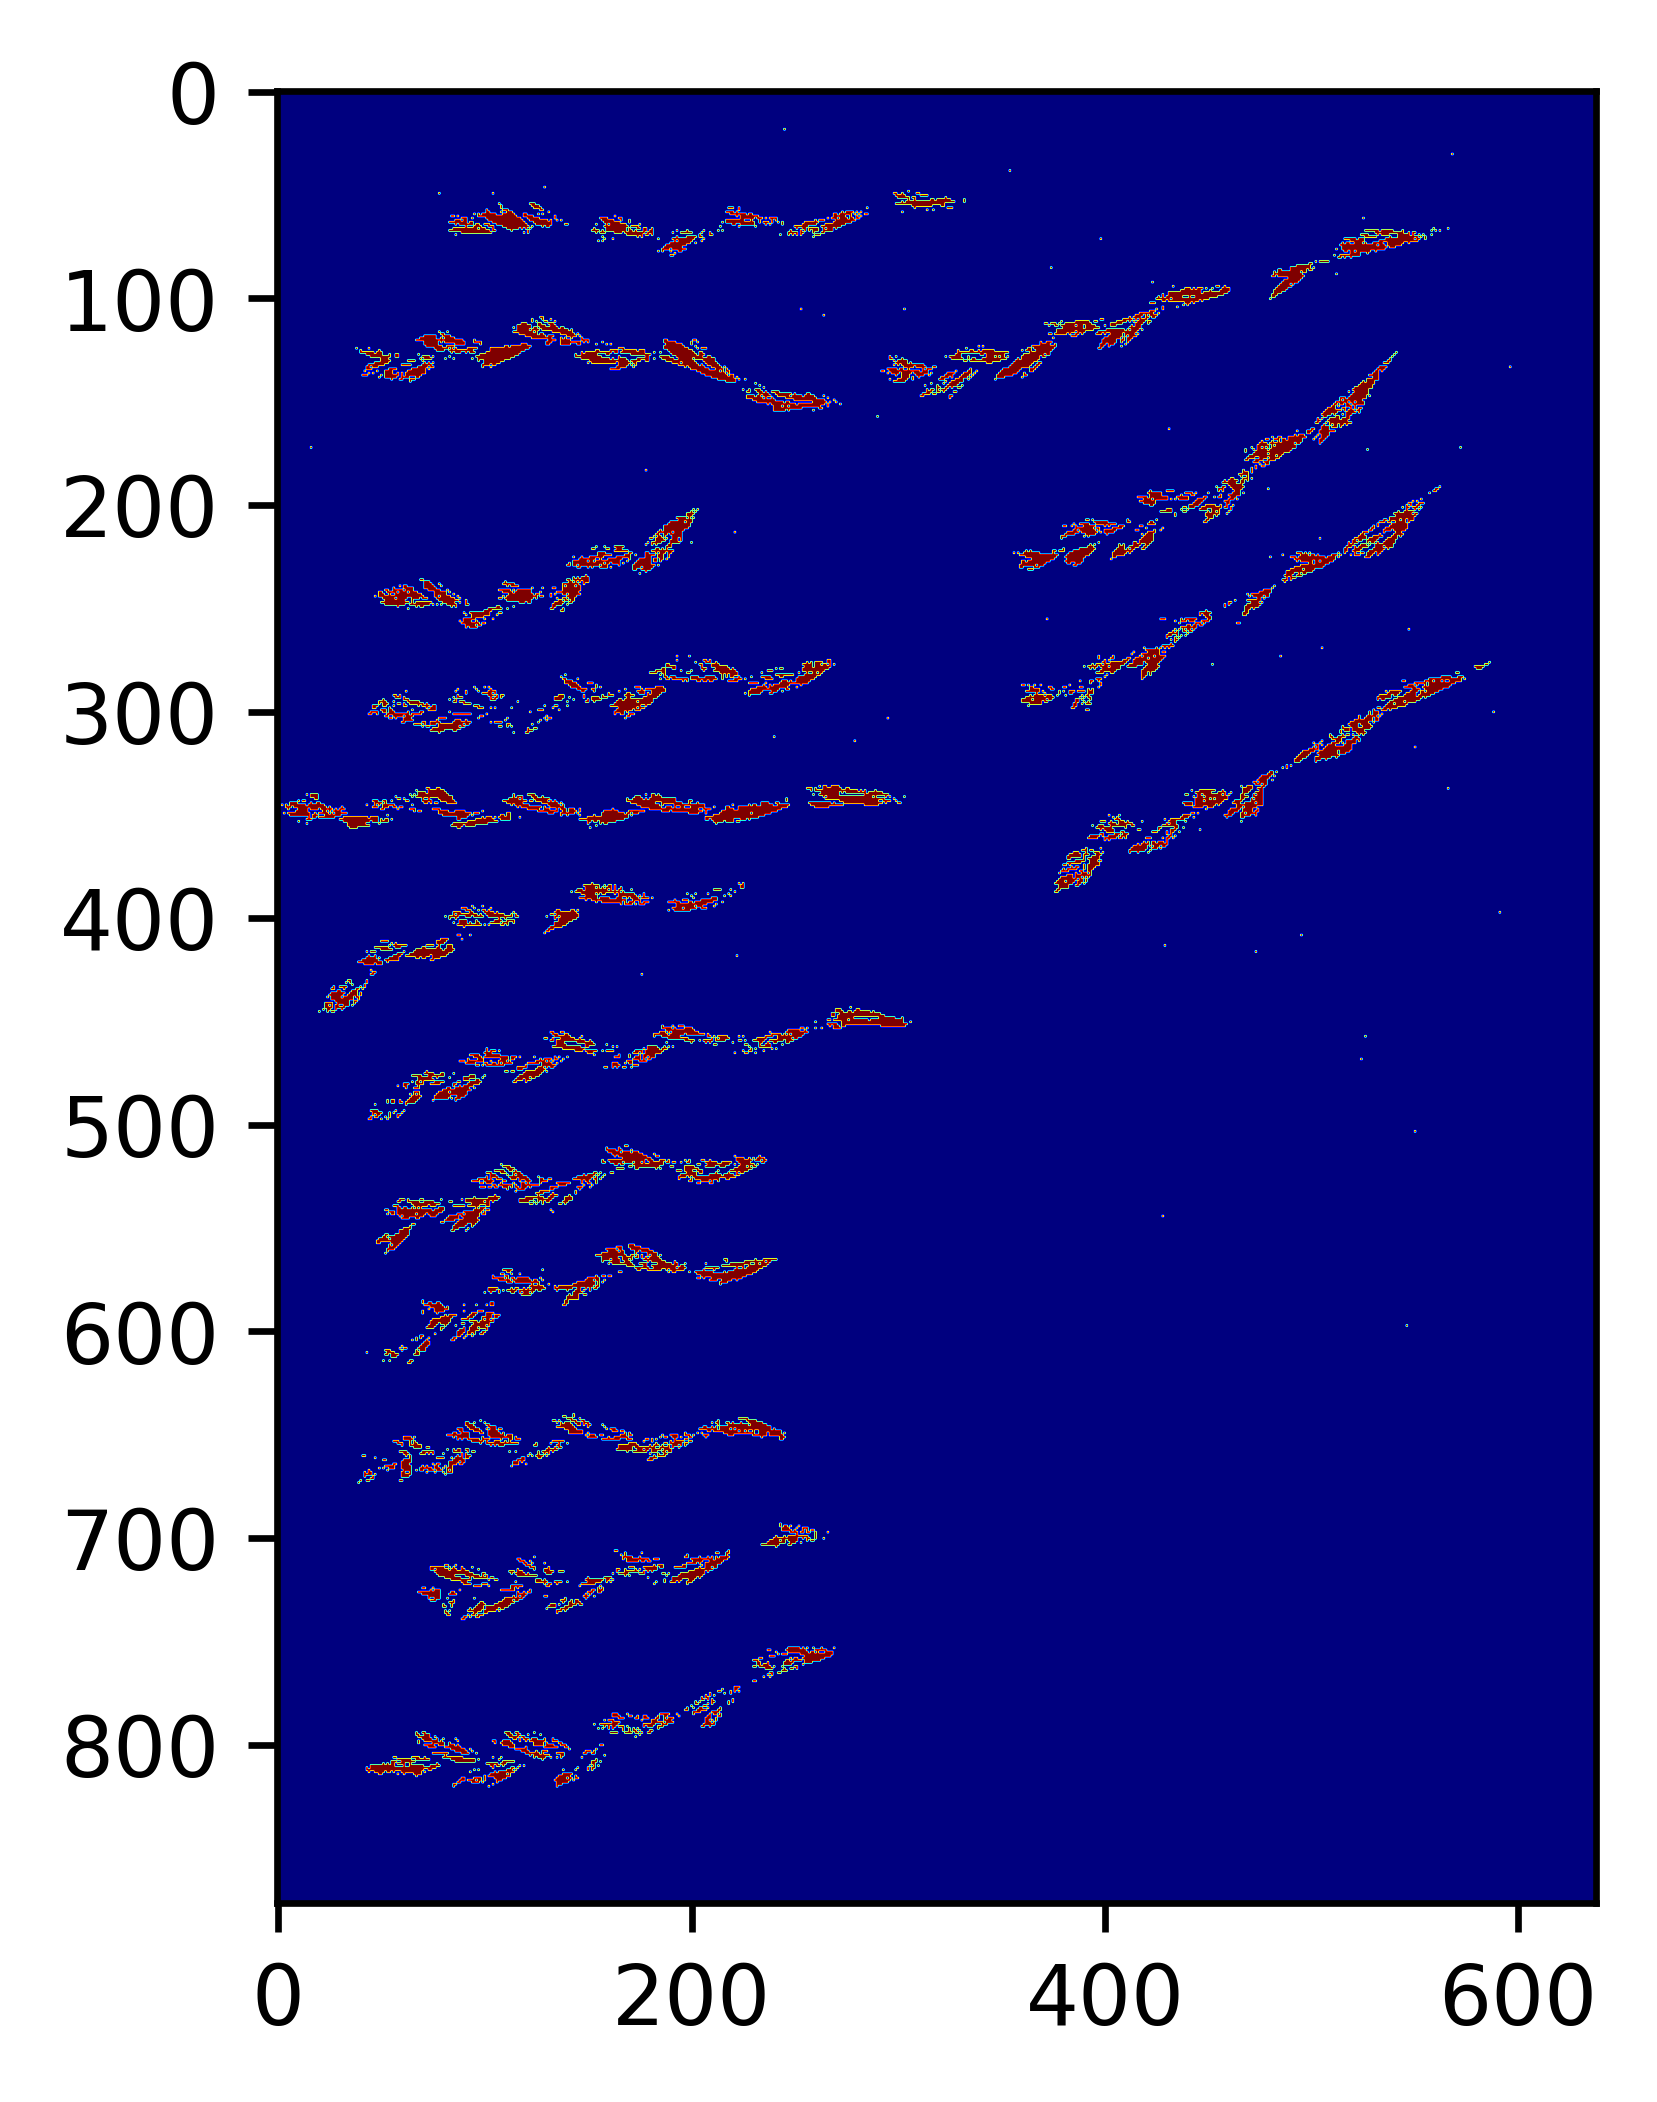

In [31]:
%%time

# result = model_SVM2.predict(X)
# result = model_RFC2.predict(X)
result = model_RFC.predict(X)

segmented = result.reshape((img.shape))

from matplotlib import pyplot as plt
plt.imshow(segmented, cmap ='jet')
# plt.imsave('Models/RFC_100_estim_resizeF08.jpg', segmented_RFC, cmap ='jet', dpi=600)

## Store models for future use

### Random Forest

In [26]:
%%time

#You can store the model for future use. In fact, this is how you do machine elarning
#Train on training images, validate on test images and deploy the model on unknown images. 

import pickle

#Save the trained model as pickle string to disk for future use
# Resize Factor = 8
# filename = "Models/sandstone_modelRFC_resizeF08"
filename_RFC = "Models/modelRFC_100_resizeF08"
pickle.dump(model_RFC, open(filename_RFC, 'wb'))

# #To test the model on future datasets
# loaded_model = pickle.load(open(filename_RFC, 'rb'))
# result = loaded_model.predict(X)

# segmented = result.reshape((img.shape))

# from matplotlib import pyplot as plt
# plt.imshow(segmented, cmap ='jet')
# # plt.imsave('Models/RFC_1000_estim_resizeF08.jpg', segmented, cmap ='jet')

Wall time: 1.45 s


In [27]:
%%time

#To test the model on future datasets
loaded_model = pickle.load(open(filename_RFC, 'rb'))
result = loaded_model.predict(X)

segmented_RFC = result.reshape((img.shape))

from matplotlib import pyplot as plt
plt.imshow(segmented_RFC, cmap ='jet')
plt.imsave('Models/RFC_100_estim_resizeF08.jpg', segmented_RFC, cmap ='jet', dpi=600)

NameError: name 'img' is not defined

### SVM

In [28]:
%%time

filename_SVM = "Models/modelSVM_100_resizeF08"
pickle.dump(model_SVM, open(filename_SVM, 'wb'))



Wall time: 17.9 ms


In [29]:
%%time

#To test the model on future datasets
loaded_model = pickle.load(open(filename_SVM, 'rb'))
result = loaded_model.predict(X)

segmented_SMV = result.reshape((img.shape))

from matplotlib import pyplot as plt
plt.imshow(segmented_SMV, cmap ='jet')
plt.imsave('Models/SVM_100_estim_resizeF08.jpg', segmented_SMV, cmap ='jet', dpi=600)

NameError: name 'img' is not defined

In [ ]:
# Sources:
# https://www.datarmatics.com/data-science/logistic-regression-in-python-with-the-titanic-dataset/
# https://www.youtube.com/watch?v=L9BLLWRtnOU&t=1s&ab_channel=KindsonTheTechPro

In [30]:
%%time

# Using simple Decision Tree classifier
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier(max_depth=5)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.9693367901887102

In [31]:
%%time

y_pred = dt_clf.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Wall time: 1.35 s


array([[1468776,    6393],
       [  40714,   20388]], dtype=int64)

In [38]:
plt.imshow(y_pred.reshape((img.shape)))

ValueError: cannot reshape array of size 1536271 into shape (877,638)

In [40]:
%%time

from sklearn import ensemble
# rf_clf = ensemble.RandomForestClassifier(n_estimators=100)
# rf_clf.fit(X_train, y_train)
# rf_clf.score(X_test, y_test)

Wall time: 0 ns


In [41]:
%%time

gb_clf = ensemble.GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_clf.score(X_test, y_test)

Wall time: 23min 37s


0.9731499195128984

In [42]:
%%time

# Let's  tune this Gradient booster.
gb_clf = ensemble.GradientBoostingClassifier(n_estimators=50)
gb_clf.fit(X_train,y_train)
gb_clf.score(X_test, y_test)

Wall time: 7min 9s


0.9720648245003648